In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
pathresults = "../results/"
#pathresults = "/DUMUXDune27/DUMUX/dumux-rosi/python/paperSc/results/"
data_file_delimiter = ","

import matplotlib.ticker as mtick
import seaborn as sns
viridis = matplotlib.colormaps.get_cmap('viridis')
from matplotlib import colors

In [4]:
df = pd.read_pickle("./forEgu25.pkl") 

#outputvalsname =  ['wat','cs','cl','coa','cod','cca','ccd','css2','co2','yX','yY','yZ']
#column_names = outputvalsname + paramsets.columns.tolist()
def getnewval(df):
    #outputvalsname =  ['wat','cs','cl','coa','cod','cca','ccd','css2','co2','yX','yY','yZ']
    #column_names = outputvalsname + paramsets.columns.tolist()
    df['css']=df['css2']
    df['cxd']=df['cod']+df['ccd']
    df['cxa']=df['coa']+df['cca']
    df['cx']=df['co']+df['cc']
    df['cxd_cx']=df['cxd']/df['cx']
    df['cxa_cx']=df['cxa']/df['cx']
    df['theta']=df['wat']/df['vol']
    #df  = pd.merge(df, paramsets[['pSet', 'theta_th']], on="pSet")
    #df['csBis'] = df['cs']*df['theta']/df['theta_th']
    #df['clBis'] = df['cl']*df['theta']/df['theta_th']
    # per unit of soil volume
    df['cs_'] = df['cs']*df['theta']
    df['cl_'] = df['cl']*df['theta']
    #df.loc[df['scenario'] == "earlyDry",'scenario']="earlyDry"  # Select subset where 'pSet' equals the current value
    
    solidDensity = 2650 # [kg/m^3 solid] #taken from google docs TraiRhizo
    solidMolarMass = 60.08e-3 # [kg/mol] 
    thetaS= 0.43
    mgC_per_molC=12.011*1000
    
    massBulkDensity = solidDensity*(1.- thetaS) *1000 /1e6 # [kg/m^3 scv] * [g/kg] * [m3/cm3] = g/cm3

    # mol/cm3 scv to mg C pool/g C mineral
    if True:
        for nnn in ['cs_','cl_','co','cc','coa','cod','cca','ccd','css2']:
            # mol C/cm3 *  
            df[nnn+'_mass'] = df[nnn]*mgC_per_molC / massBulkDensity
    return df
df = getnewval(df)
dfa = df
pSet2Keep = []

In [9]:

allset= df['scenario'].unique()
psetCaCxa = set(set( dfa[(dfa['cxa_cx']>=0.6)]['scenario'].unique())  )
#psetCaCxb = set(set( dfb2[(dfb2['cxa_cx']>=0.7)]['pSet'].unique())  )
pSethighC =  set(set( df[df['cs']>7e-5]['scenario'].unique())  ) #set(set( df[df['cs']>5e-4]['pSet'].unique())  ) #
pSethighCoCc = set(set( df[(df['co'] + df['cc'])>2e-3]['scenario'].unique())  )
pSethighCoCcBis = set(set( df[(df['co'] > df['cc'])]['scenario'].unique())  )
print(psetCaCxa, pSethighC, pSethighCoCc, pSethighCoCcBis)


{'baseline'} set() set() set()


In [10]:
print(max(df[df['scenario']=="earlyDry"]['co'] + df[df['scenario']=="earlyDry"]['cc']),
      max(df[df['scenario']=="baseline"]['co'] + df[df['scenario']=="baseline"]['cc']),
      max(df[df['scenario']=="lateDry"]['co'] + df[df['scenario']=="lateDry"]['cc']))

0.0011579836707677703 0.0014269873645288323 0.0011727355929694917


In [11]:
def olgvscopo(df, unique_values=None):
    doBlack = False
    if unique_values is None:
        doBlack = True
        unique_values = df['scenario'].unique()
    rgb_values = sns.color_palette("Set2", 99)
    color_map = dict(zip(unique_values,rgb_values))

    for value in unique_values:
        subset = df[df['scenario'] == value]  # Select subset where 'pSet' equals the current value
        col =color_map[value]
        edgecolors=  (0.0, 0.0, 0.0)
        if doBlack:
            if value in pSet2Keep:
                col = (0.0, 0.0, 0.0)
                edgecolors=  (1,1,1)
        col = colors.to_hex(col)
        plt.scatter(subset['cc'], subset['co'], alpha=0.3, 
                    c = col,label=f'{value}' #color_map[value]
                   )
    if doBlack:
        for value in pSet2Keep:
            subset = df[df['scenario'] == value]  # Select subset where 'pSet' equals the current value

            col = (0.0, 0.0, 0.0)
            edgecolors=  (1,1,1)
            col = colors.to_hex(col)
            plt.scatter(subset['cc'], subset['co'], alpha=1, 
                        c = col ,zorder=100#color_map[value]
                       )
    else:
        plt.legend()
    # Add labels and legend
    plt.xlabel('cc (mol/cm3)')
    plt.ylabel('co (mol/cm3)')
    #plt.xlabel('cc (mg C/g soil mineral)')
    #plt.ylabel('co (mg C/g soil mineral)')

    #plt.show()

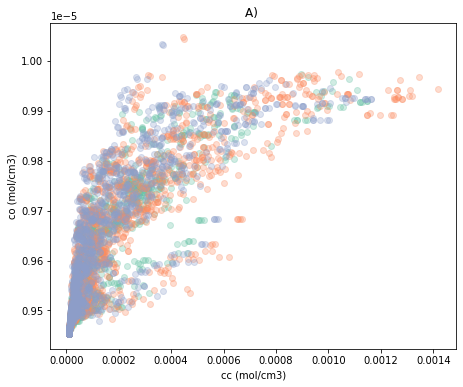

In [12]:

plt.figure(figsize=(8*2, 6*1))
plt.subplot(1, 2, 1)
plt.title(chr(ord('@')+1)+") ")#+colVar)
olgvscopo(df)

In [55]:

def bin_(dataframe, independent_variable, dependent_variable, num_bins,doLog):
    # Step 1: Define the range of each bin for the independent variable
    #bin_ranges = pd.cut(dataframe[independent_variable], bins=num_bins, include_lowest=True)
    
    #hist, bin_vales = np.histogram(dataframe[independent_variable], bins=num_bins)
    bin_vales = np.linspace(-25,0,num_bins)
    bin_ranges = pd.cut(dataframe[independent_variable], bins=bin_vales)#, include_lowest=True)
    # Step 2: Group the dataframe according to the bin ranges
    dataframe[dependent_variable+"_"]=dataframe[dependent_variable]*dataframe["vol"]
    grouped = dataframe.groupby(bin_ranges)

    # Step 3: Compute the sum of dependent variable for each bin and the mean of the independent variable
    bin_meansZ = grouped[independent_variable].mean()#bin_vales[:-1]+np.diff(bin_vales)# 
    bin_meansX = (grouped[dependent_variable+"_"]).sum()/(grouped["vol"]).sum()
    return bin_meansZ.dropna(), bin_meansX.dropna()
def bin_and_plot(dataframe, independent_variable, dependent_variable, num_bins,
                 nrows, ncols, indexsubplot, unit=None,
                 doLog=True, colVar = None, mysets=None,keeplim=True,xlabels=None):
    if colVar is not None:
        maxV = dataframe[colVar].max()
        minV = dataframe[colVar].min()
        
    # Create the plot
    #plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    plt.subplot(nrows, ncols, indexsubplot)
    # Loop to plot each line
    if mysets is None:
        mysets = df["scenario"].unique()
    #print('ames',max( dataframe[dataframe['pSet'] in np.array(mysets)][dependent_variable]))
    for i in mysets:
        df_ = dataframe[dataframe['scenario']==i].copy()
        bin_meansZ, bin_meansX = bin_(df_, independent_variable, dependent_variable, num_bins,doLog)
        #print('bin_means',bin_meansZ, 'bin_sums',bin_meansX)
        if colVar is None:
            plt.plot( bin_meansX.values, bin_meansZ,label=f'{i}')
        else:
            ourVal = df_[colVar].mean()
            normVal = (ourVal - minV)/(maxV - minV)
            plt.plot( bin_meansX.values, bin_meansZ,label=f'{i}',c=viridis(normVal))
            
    if unit is None:
        unit = 'mol/cm3'
    if keeplim == True:
        plt.xlim(np.min(dataframe[dependent_variable])*0.95, np.max(dataframe[dependent_variable])*1.05)
    plt.ylabel('Mean depth (cm)', fontsize=20)
    plt.yticks(fontsize=18)
    if xlabels is None:
        plt.xlabel('Mean ' + dependent_variable+' ('+unit+')', fontsize=20)
    else:
        
        plt.xlabel('Mean ' + xlabels[dependent_variable]+' ('+unit+')', fontsize=20)
    plt.xticks(rotation=30, fontsize=18)
    #plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    if doLog:
        plt.yscale('log')
    if colVar is not None:
        plt.title(chr(ord('@')+indexsubplot)+") ", fontsize=22)#+colVar)
    else:
        plt.title(chr(ord('@')+indexsubplot)+") ", fontsize=22)#+colVar)
        if indexsubplot == 1:
            plt.legend(loc="center left", fontsize=22)
    plt.grid(True)
    
    plt.tight_layout()
    

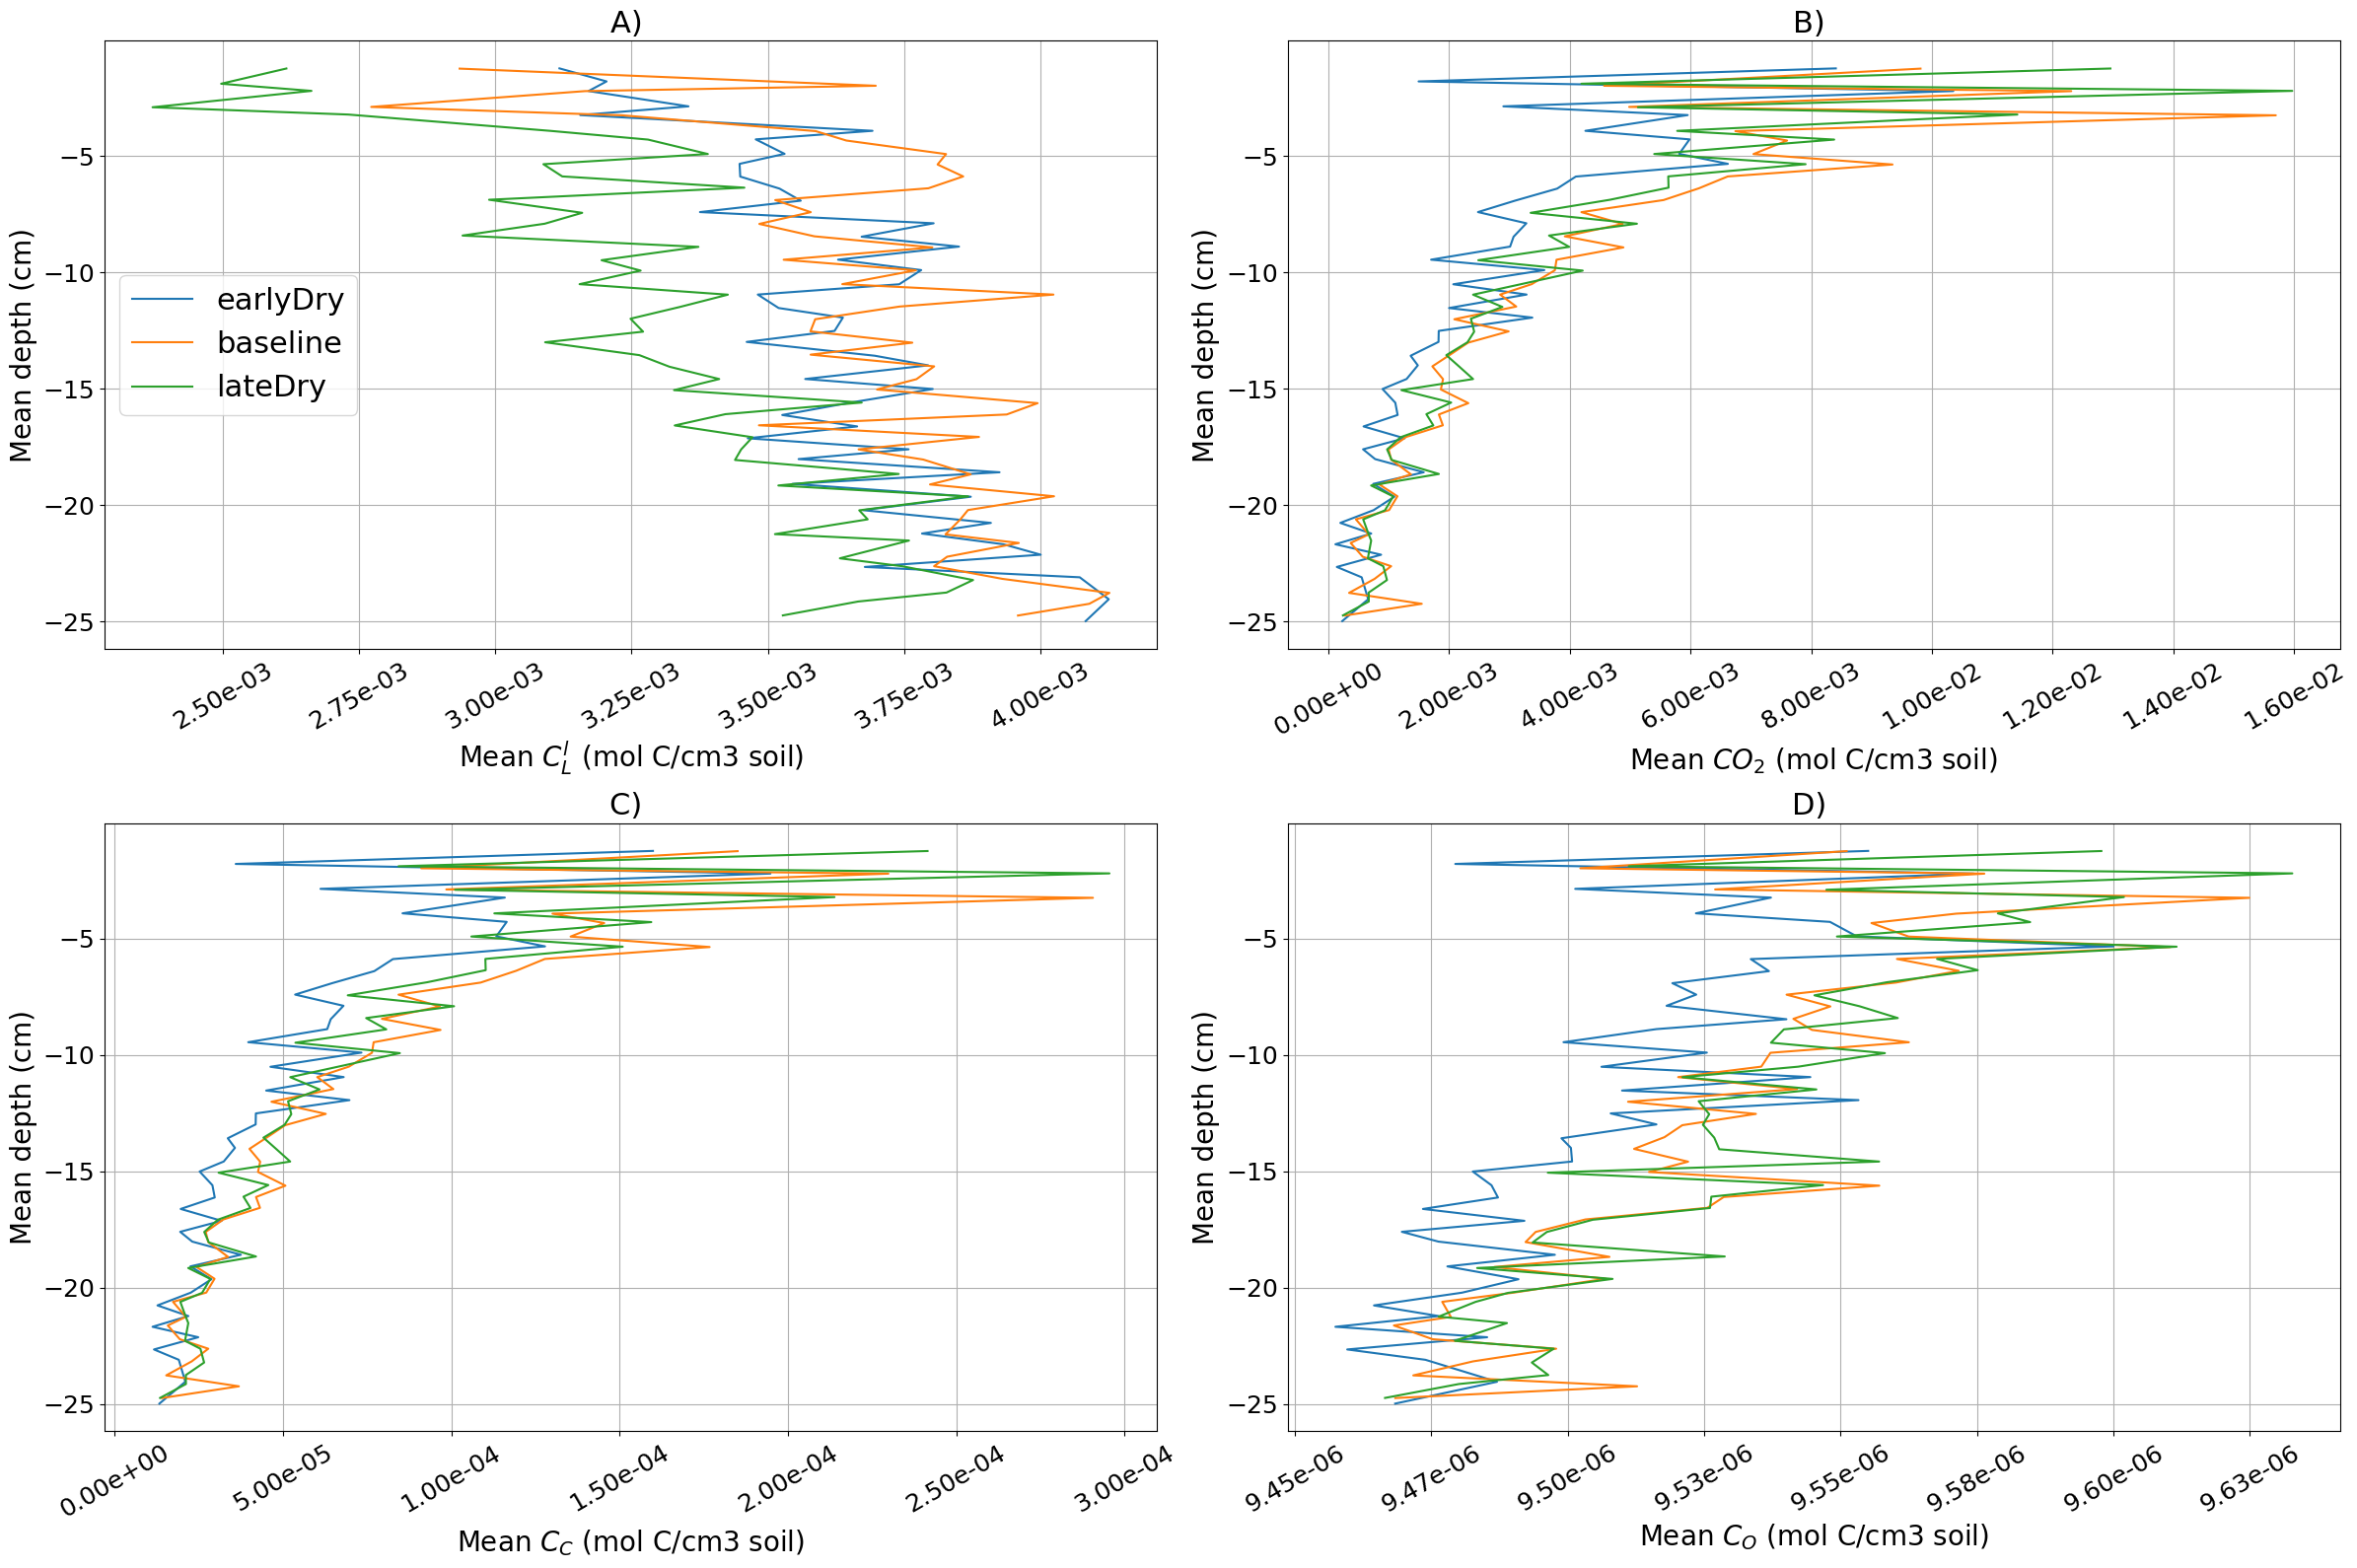

In [56]:
colvars = None#'CS_init'
dfa['height'] = dfa['yZ']
mg_per_mol = 12.011 *1000 # g/mol

solidDensity = 2650 # [kg/m^3 solid] #taken from google docs TraiRhizo
solidMolarMass = 60.08e-3 # [kg/mol] 

# theta_r, theta_s, alpha, n, Ks
soil =  [0.08, 0.43, 0.04, 1.6, 50]#[0.045, np.nan, 0.04, 1.6, 50]

# [mol / m3 solid] =[kg/m^3 solid] / [kg/mol] 
solidMolDensity = solidDensity/solidMolarMass
# [mol / m3 scv] = [mol / m3 solid] * [m3 solid /m3 space]
bulkDensity_m3 = solidMolDensity*(1.- soil[1])
bulkDensity_cm3 = bulkDensity_m3 / 1e6 # [mol / cm3 scv] 
# g soil/cm3 soil
solidDensity_gcm3 = solidDensity/1e6*1000 # [kg/m^3 solid] * [m3/cm3] * [g/kg]
dfa['CLl']=dfa['cs_']#*dfa['vol']
dfa['cs_/css']=dfa['cs_']/dfa['css']
idsplot = [1,2,3,4]
units = [ 'mol C/cm3 soil','mol C/cm3 soil','mol C/cm3 soil','mol C/cm3 soil']
xlabels = {'CLl': '$C_L^l$','co2': '$CO_2$','cc': '$C_C$','co': '$C_O$' }  
plt.figure(figsize=(8*3, 8*2))
for nn, dep in enumerate(['CLl','co2','cc','co']): #(['CHl','css','cs_/css']):
    bin_and_plot(dfa, 'height', dep, 50,
                 2, 2, idsplot[nn], 
                 doLog=False, colVar= colvars, unit = units[nn],keeplim=False,
                xlabels=xlabels)#[nn])
    
plt.show()

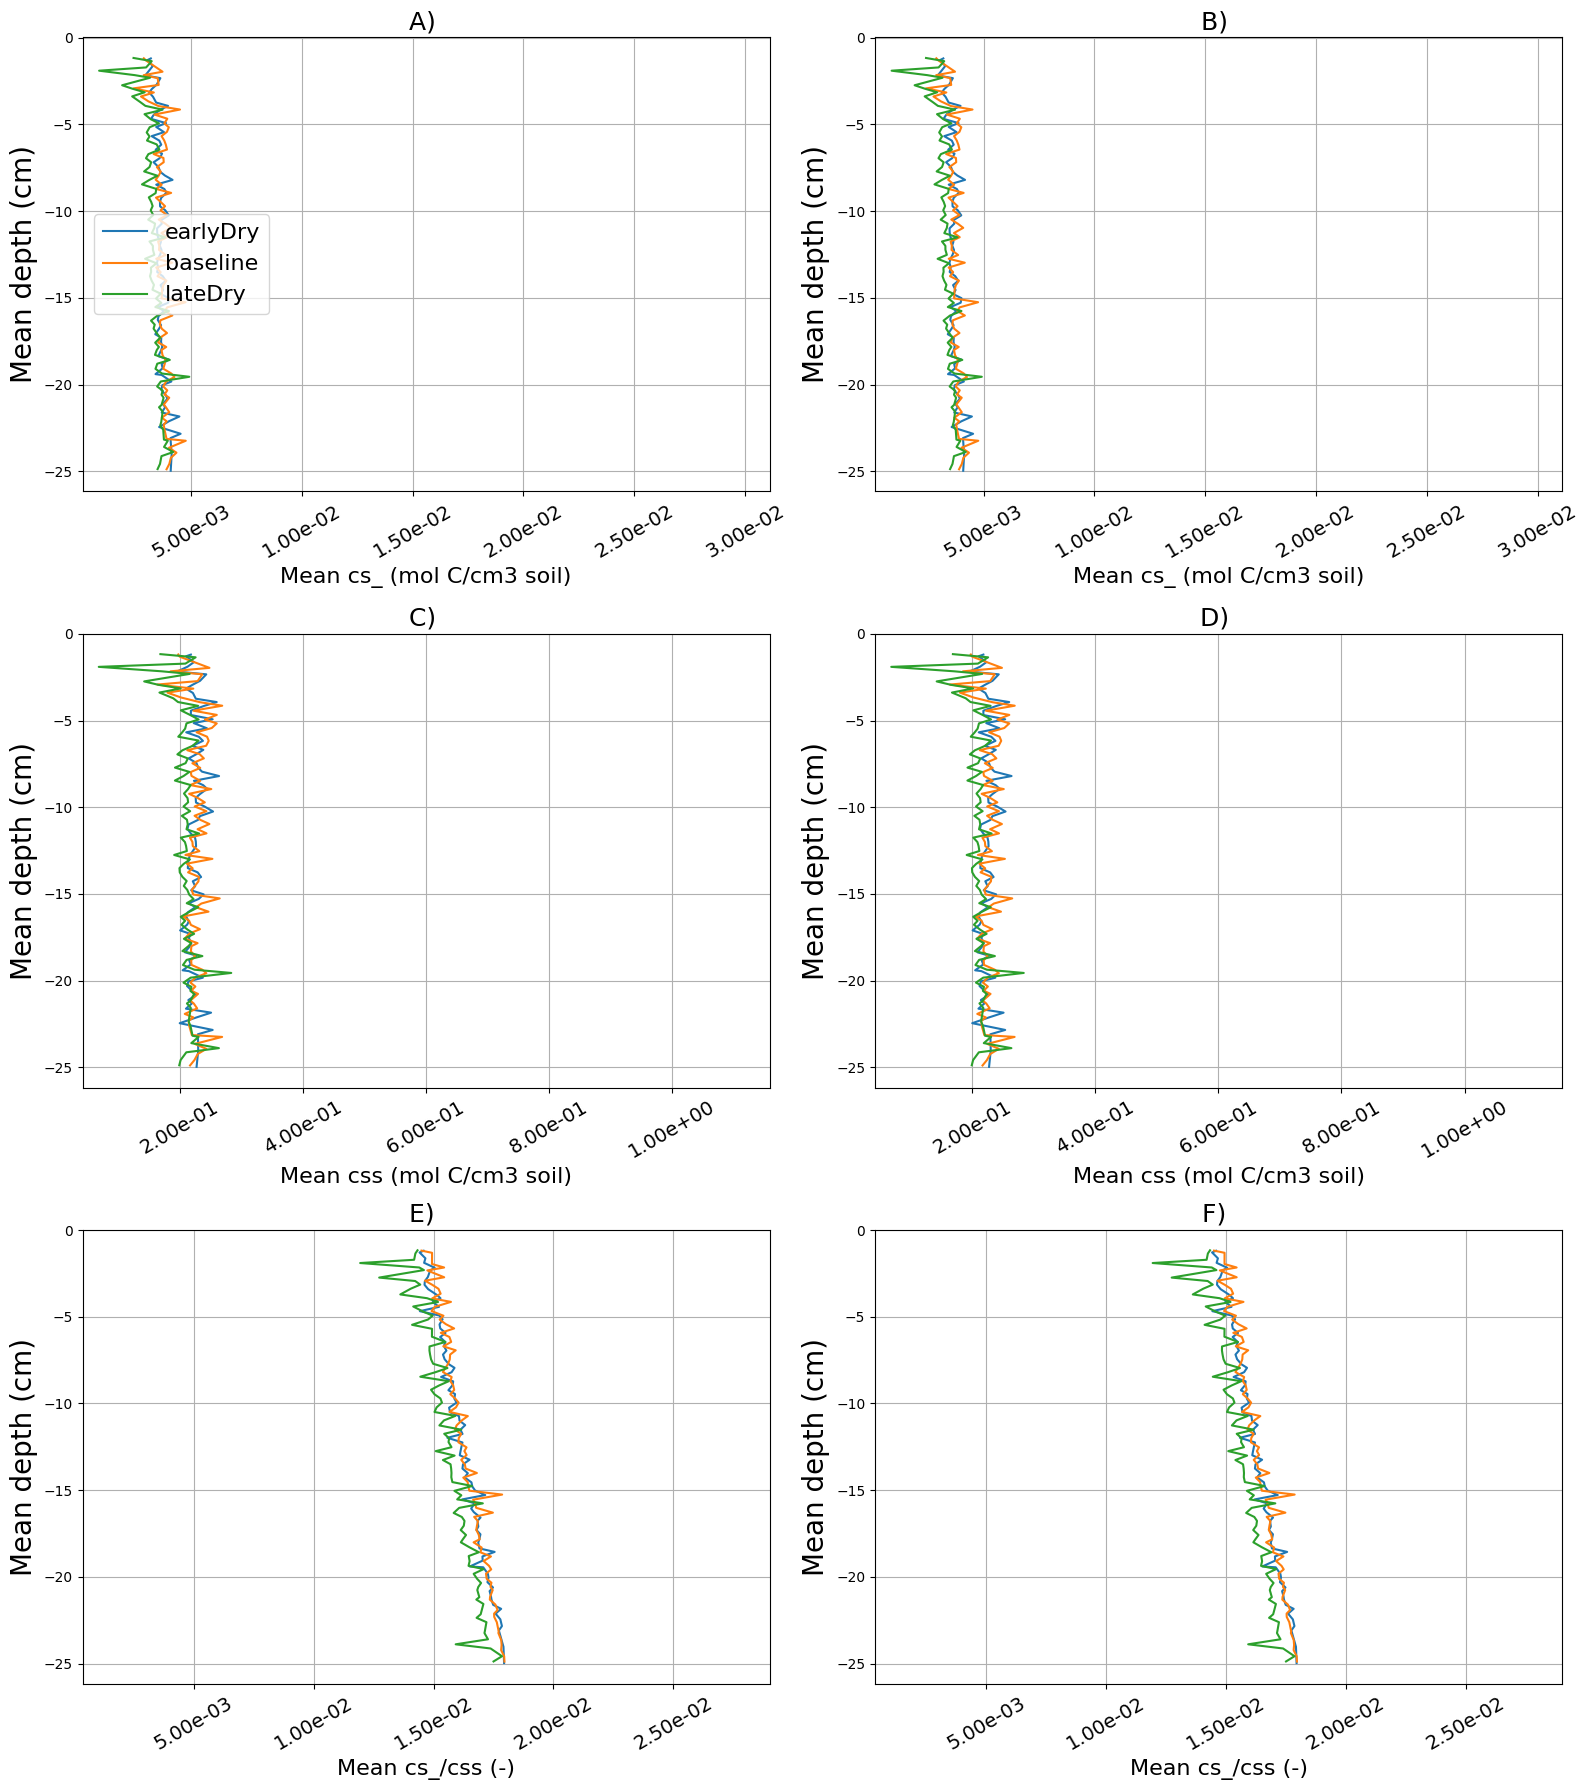

In [45]:
colvars = None#'CS_init'
dfa['height'] = dfa['yZ']
mg_per_mol = 12.011 *1000 # g/mol

solidDensity = 2650 # [kg/m^3 solid] #taken from google docs TraiRhizo
solidMolarMass = 60.08e-3 # [kg/mol] 

# theta_r, theta_s, alpha, n, Ks
soil =  [0.08, 0.43, 0.04, 1.6, 50]#[0.045, np.nan, 0.04, 1.6, 50]

# [mol / m3 solid] =[kg/m^3 solid] / [kg/mol] 
solidMolDensity = solidDensity/solidMolarMass
# [mol / m3 scv] = [mol / m3 solid] * [m3 solid /m3 space]
bulkDensity_m3 = solidMolDensity*(1.- soil[1])
bulkDensity_cm3 = bulkDensity_m3 / 1e6 # [mol / cm3 scv] 
# g soil/cm3 soil
solidDensity_gcm3 = solidDensity/1e6*1000 # [kg/m^3 solid] * [m3/cm3] * [g/kg]

dfa['cs_'] = dfa['cs']*dfa['theta']*mg_per_mol/solidDensity_gcm3
dfa['cl_'] = dfa['cl']*dfa['theta']*mg_per_mol/solidDensity_gcm3
dfa['css'] = dfa['css2']*mg_per_mol/solidDensity_gcm3
dfa['cs_/css']=dfa['cs_']/dfa['css']
idsplot = [1,3,5]
units = [ 'mol C/cm3 soil','mol C/cm3 soil','-']
plt.figure(figsize=(8*2, 6*3))
for nn, dep in enumerate(['cs_','css','cs_/css']):
    bin_and_plot(dfa, 'height', dep, 100,
                 3, 2, idsplot[nn], 
                 doLog=False, colVar= colvars, unit = units[nn],keeplim=True)#[nn])
    
idsplot = [2,4,6]
for nn, dep in enumerate(['cs_','css','cs_/css']):
    bin_and_plot(dfa, 'height', dep, 100,
                 3, 2, idsplot[nn], 
                 doLog=False, colVar= None, mysets=pSet2Keep, 
                 unit = units[nn],keeplim=True)#[nn])
plt.show()

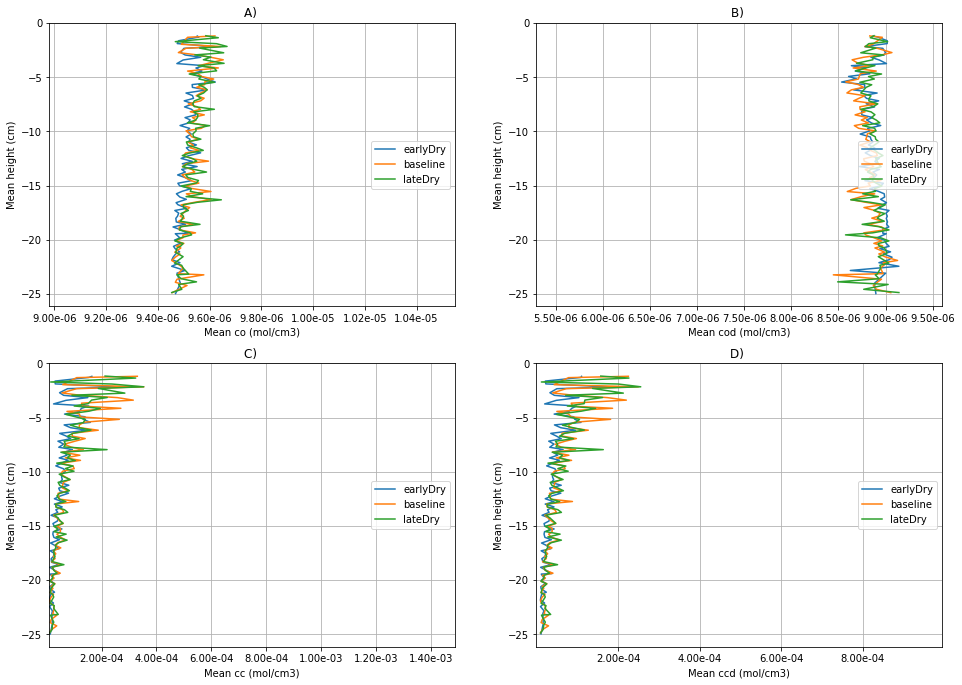

In [16]:
colvars = None#'CS_init'

idsplot = [1,2,3,4]
plt.figure(figsize=(8*2, 6*4))
for nn, dep in enumerate(['co','cod','cc','ccd']):
    bin_and_plot(dfa, 'height', dep, 100,
                 4, 2, idsplot[nn], 
                 doLog=False, colVar= colvars)#[nn])
    

plt.show()

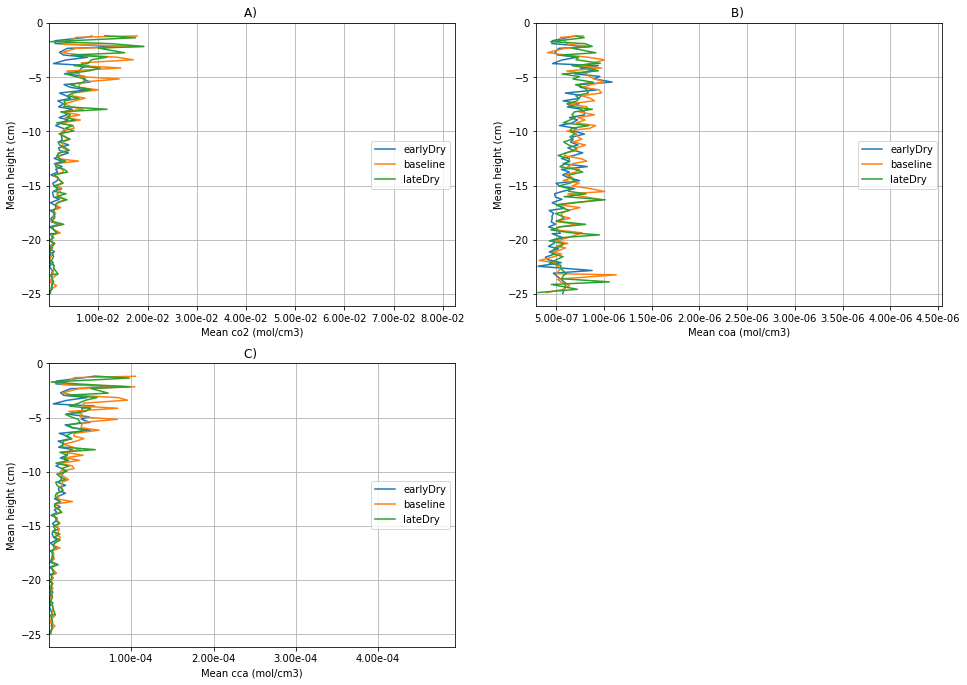

In [17]:
colvars = None#'CS_init'

idsplot = [1,2,3,4]
plt.figure(figsize=(8*2, 6*4))
for nn, dep in enumerate(['co2','coa','cca']):
    bin_and_plot(dfa, 'height', dep, 100,
                 4, 2, idsplot[nn], 
                 doLog=False, colVar= colvars)#[nn])
    

plt.show()

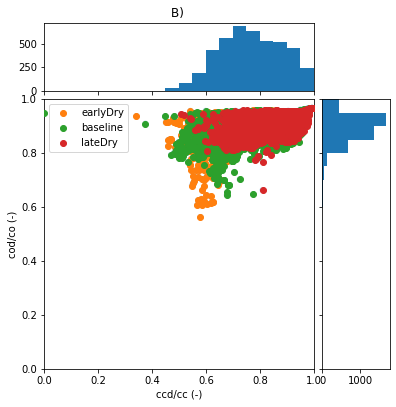

In [18]:
def scatter_hist(x, y,sets, ax, ax_histx, ax_histy,extra_val=None):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    
    ax.scatter(x, y,
               #c=df['vol'],
               alpha=0.3, edgecolors ='none')
 
    for vall in extra_val:#pSet2Keep:
        is5x = x[np.where(sets == vall)[0] ] # Select subset where 'pSet' equals the current value
        is5y = y[np.where(sets == vall)[0] ] # Select subset where 'pSet' equals the current value
        col = (0.0, 0.0, 0.0)
        ax.scatter(is5x, is5y, alpha=1, 
                    zorder=100,label=f'{vall}'#color_map[value]
                   )
    # now determine nice limits by hand:
    binwidth = 0.05
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    ax.legend()
    bins = np.arange(-lim, lim + binwidth, binwidth)
    
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
# Start with a square Figure.


fig = plt.figure(figsize=(6, 6))

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])

ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
plt.title(chr(ord('@')+2)+") ")
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax.set_xlabel('ccd/cc (-)')
ax.set_ylabel('cod/co (-)')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
# Draw the scatter plot and marginals.
scatter_hist((dfa['ccd'])/dfa['cc'],(dfa['cod'])/dfa['co'], dfa['scenario'], ax, ax_histx, ax_histy,df["scenario"].unique())


[]

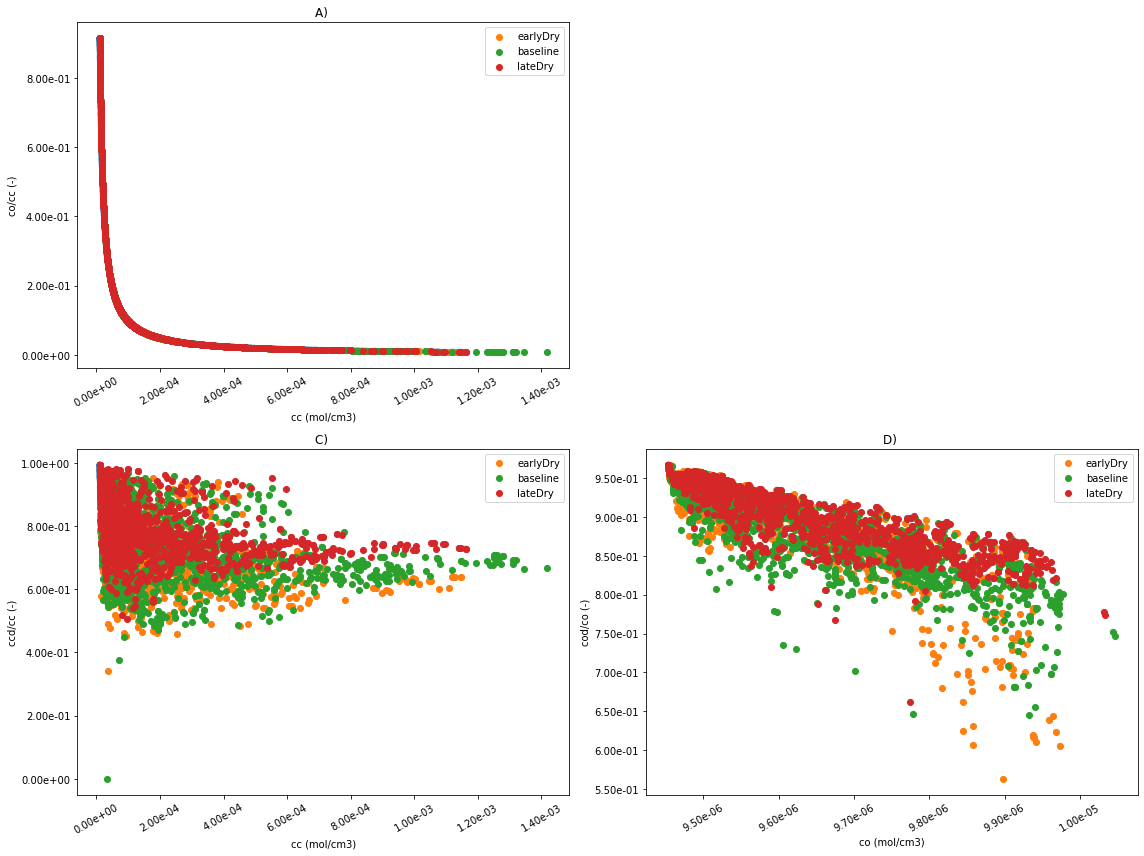

In [19]:
pSet2Keep = df["scenario"].unique()


plt.figure(figsize=(8*2, 6*2))
plt.subplot(2, 2, 1)
plt.title(chr(ord('@')+1)+") ")#+colVar)

df=dfa
plt.scatter((df['cc']),(df['co'])/df['cc'], #np.log(df['cc']),np.log(df['co']), 
            #c=df['pSet'],
            alpha=0.3, edgecolors ='none')
for vall in pSet2Keep:
    subset = df[df['scenario'] == vall]  # Select subset where 'pSet' equals the current value
    plt.scatter((subset['cc']),(subset['co'])/subset['cc'], alpha=1, 
                zorder=100,label=f'{vall}'
               )
    plt.legend()
    
plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':100})
#plt.title(nn)
#plt.colorbar()
plt.xlabel('cc (mol/cm3)')
plt.ylabel('co/cc (-)')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.xticks(rotation=30)


plt.subplot(2, 2, 3)
plt.title(chr(ord('@')+3)+") ")#+colVar)
plt.scatter((df['cc']),(df['ccd'])/df['cc'], #np.log(df['cc']),np.log(df['co']), 
            #c=df['pSet'],
            alpha=0.3, edgecolors ='none')
for vall in pSet2Keep:
    subset = df[df['scenario'] == vall]  # Select subset where 'pSet' equals the current value
    
    plt.scatter((subset['cc']),(subset['ccd'])/subset['cc'], alpha=1, 
                zorder=100,label=f'{vall}'
               )
    plt.legend()
plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':100})
#plt.title(nn)
#plt.colorbar()
plt.xlabel('cc (mol/cm3)')
plt.ylabel('ccd/cc (-)')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.xticks(rotation=30)

plt.legend()
plt.subplot(2, 2, 4)
plt.title(chr(ord('@')+4)+") ")#+colVar)

plt.scatter((df['co']),(df['cod'])/df['co'], #np.log(df['cc']),np.log(df['co']), 
            #c=df['pSet'],
            alpha=0.3, edgecolors ='none')
for vall in pSet2Keep:
    subset = df[df['scenario'] == vall]  # Select subset where 'pSet' equals the current value
    plt.scatter((subset['co']),(subset['cod'])/subset['co'], alpha=1, 
               zorder=100,label=f'{vall}'
               )
    plt.legend()
    
plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':100})
#plt.title(nn)
#plt.colorbar()
plt.xlabel('co (mol/cm3)')
plt.ylabel('cod/co (-)')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.xticks(rotation=30)

plt.tight_layout()
plt.plot()

19 0.18401064918343393 0.47319332355433297 0.026561855972647458
83 0.20546391415521537 0.5142439536037406 0.03793704809084346
76 0.2678046782694152 0.594778268000773 0.024837111668440093
47 0.14650066920692945 0.378201000296348 0.0484420751325109


In [430]:
print(len(set( df['pSet'].unique())-psetCaCxa),
len(set( df['pSet'].unique())- psetCaCxa-pSethighCoCc))

22 21


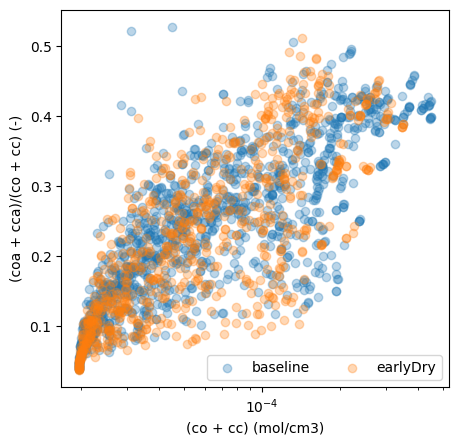

In [27]:
df = dfa
unique_values =set( df['scenario'].unique())#-psetCaCxa
#unique_values.add(57)
rgb_values = sns.color_palette("Set2", len(unique_values))
color_map = dict(zip(unique_values,rgb_values))

for value in unique_values:
    subset = df[df['scenario'] == value]  # Select subset where 'pSet' equals the current value
    #col = colors.to_hex(color_map[value])
    plt.scatter(subset['cx'], subset['cxa']/subset['cx'], alpha=0.3, 
               label=str(value)#, c = col
               )#color_map[value])

# Add labels and legend
plt.xscale('log')
plt.xlabel('(co + cc) (mol/cm3)')
plt.ylabel('(coa + cca)/(co + cc) (-)')
plt.legend(ncol=2)
plt.show()

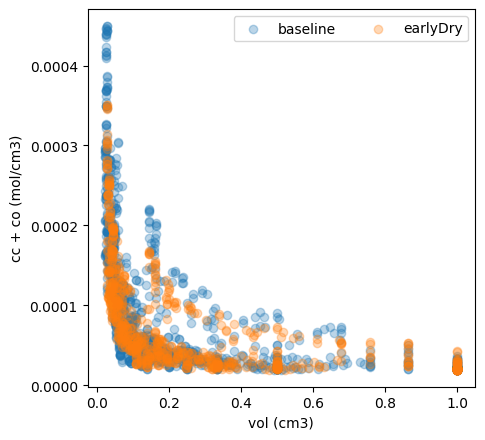

In [29]:
df=dfa
unique_values = set( df['scenario'].unique())#- psetCaCxa-pSethighCoCc
rgb_values = sns.color_palette("Set2", 99)
color_map = dict(zip(unique_values,rgb_values))

for value in unique_values:
    subset = df[df['scenario'] == value]  # Select subset where 'pSet' equals the current value
    col = colors.to_hex(color_map[value])
    plt.scatter(subset['vol'], subset['cc'] + subset['co'], alpha=0.3,  
                label=str(value)#c = col
               )#color_map[value])


# Add labels and legend
plt.xlabel('vol (cm3)')
plt.ylabel('cc + co (mol/cm3)')
plt.legend(ncol=2)
plt.show()

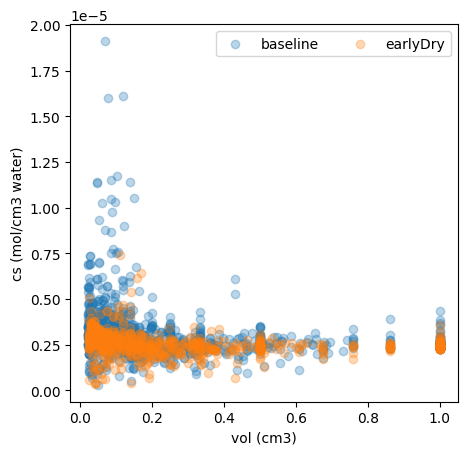

In [31]:
df=dfa
unique_values = set( df['scenario'].unique())#- psetCaCxa-pSethighCoCc-pSethighC
rgb_values = sns.color_palette("Set2", 99)
color_map = dict(zip(unique_values,rgb_values))

for value in unique_values:
    subset = df[df['scenario'] == value]  # Select subset where 'pSet' equals the current value
    col = colors.to_hex(color_map[value])
    plt.scatter(subset['vol'], subset['cs'], alpha=0.3,  
                label=str(value)#c = col
               )#color_map[value])


# Add labels and legend
plt.xlabel('vol (cm3)')
plt.ylabel('cs (mol/cm3 water)')
plt.legend(ncol=2)

plt.show()

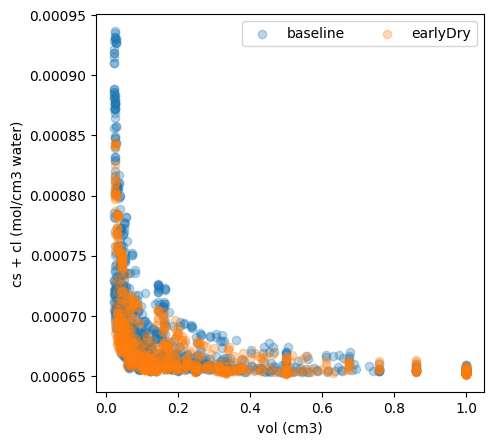

In [32]:
df=dfa
unique_values = set( df['scenario'].unique())#- psetCaCxa-pSethighCoCc-pSethighC
rgb_values = sns.color_palette("Set2", 99)
color_map = dict(zip(unique_values,rgb_values))

for value in unique_values:
    subset = df[df['scenario'] == value]  # Select subset where 'pSet' equals the current value
    col = colors.to_hex(color_map[value])
    plt.scatter(subset['vol'], subset['cs']+subset['cl'], alpha=0.3,  
                label=str(value)#c = col
               )#color_map[value])


# Add labels and legend
plt.xlabel('vol (cm3)')
plt.ylabel('cs + cl (mol/cm3 water)')
plt.legend(ncol=3)
plt.show()


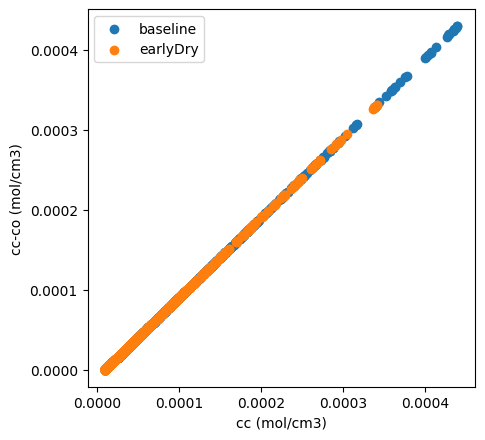

In [33]:

df=dfa
unique_values = set( df['scenario'].unique())#- psetCaCxa-pSethighCoCc-pSethighC-pSethighCoCcBis
rgb_values = sns.color_palette("Set2", len(unique_values))
color_map = dict(zip(unique_values,rgb_values))

for value in unique_values:
    subset = df[df['scenario'] == value].copy()  # Select subset where 'pSet' equals the current value
    subset['cc-co']= subset['cc']-subset['co']
    mehrCo = subset[subset['cc-co']<0]
    col = colors.to_hex(color_map[value])
    plt.scatter(subset['cc'], subset['cc-co'], #alpha=0.3,  
                label=str(value)#c = col
               )#color_map[value])

# Add labels and legend
plt.xlabel('cc (mol/cm3)')
plt.ylabel('cc-co (mol/cm3)')
plt.legend()
plt.show()


In [436]:
set( df['pSet'].unique())- psetCaCxa-pSethighCoCc-pSethighC-pSethighCoCcBis

{19, 47, 76, 83}

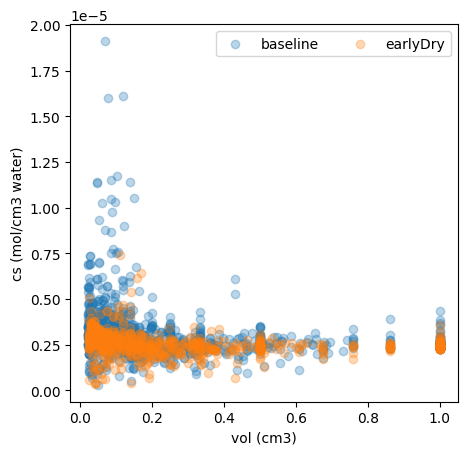

In [34]:
df=dfa
unique_values = set( df['scenario'].unique())#- psetCaCxa-pSethighCoCc-pSethighC-pSethighCoCcBis
rgb_values = sns.color_palette("Set2", 99)
color_map = dict(zip(unique_values,rgb_values))

for value in unique_values:
    subset = df[df['scenario'] == value]  # Select subset where 'pSet' equals the current value
    col = colors.to_hex(color_map[value])
    plt.scatter(subset['vol'], subset['cs'], alpha=0.3,  
                label=str(value)#c = col
               )#color_map[value])


# Add labels and legend
plt.xlabel('vol (cm3)')
plt.ylabel('cs (mol/cm3 water)')
plt.legend(ncol=2)

plt.show()

In [35]:
df = dfa
unique_values = set( df['scenario'].unique())#- psetCaCxa-pSethighCoCc-pSethighC-pSethighCoCcBis
unique_values = unique_values #- set([57,74])#.add(57)
rgb_values = sns.color_palette("Set2", len(unique_values))
color_map = dict(zip(unique_values,rgb_values))

df['cs_/css']=df['cs_']/df['css']
for value in unique_values:
    subset = dfa[dfa['scenario'] == value].copy()  # Select subset where 'pSet' equals the current value
    subset['cc-co']= subset['cc']-subset['co']
    print(value,np.mean(subset['cxa_cx']),np.max(subset['cxa_cx']), 
          np.mean(subset['cs_/css']), np.mean(subset['cs']))

baseline 0.24309801428191188 0.528148150145051 0.01641245651005144 3.095457915356136e-06
earlyDry 0.22545705743623082 0.5116124169789045 0.015965430638313703 2.557291151366571e-06


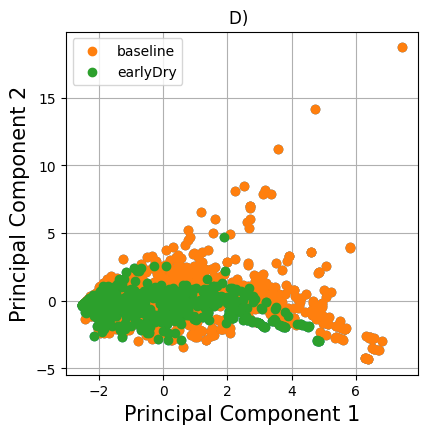

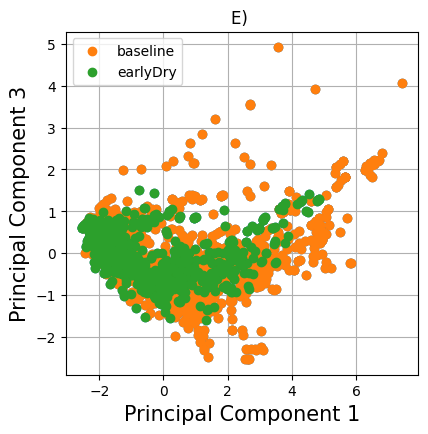

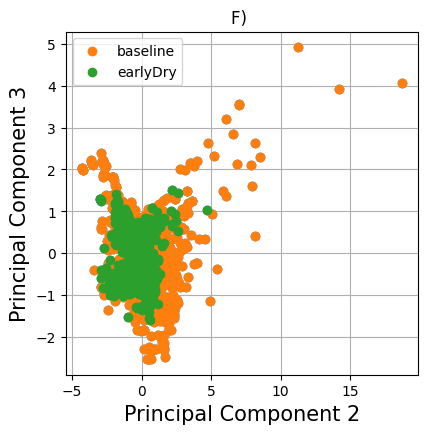

In [39]:
import matplotlib.ticker as mtick
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import matplotlib.markers as markers

import matplotlib.markers as markers

# Get a list of all available markers
marker_list = list(markers.MarkerStyle.markers.keys())

outputvalsname =  ['cs','coa','cod','cca','ccd','co2','css2']# 'co','cc',#'cl',
takeOut =[]


selectedSets = set( df['scenario'].unique())#- psetCaCxa-pSethighCoCc-pSethighC-pSethighCoCcBis


# Separating out the features
x = dfa[outputvalsname]

# Separating out the target
y = df['scenario']
target = df['scenario']# pd.DataFrame(data = y , columns = ['pSet_id'])

# Standardizing the features
x = StandardScaler().fit_transform(x)

numComp = 3

pca = PCA(n_components=numComp)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component '+str(i+1) for i in range(numComp)])


finalDf = pd.concat([principalDf, target] , axis = 1)
#finalDf['outlier'] = [idd in np.array([1, 8, 13, 14, 18, 26, 44, 51, 52, 62, 63, 64, 69, 72, 74, 78, 80, 83, 91, 92, 93]) 
#                      for idd in finalDf['pSet']]

numMarker=13
numCol = 8

marker_id =np.array( [[i]*numCol for i in range(numMarker)]).reshape(-1)[:99]
color_id  =np.array( [[i for i in range(numCol)]*numMarker]).reshape(-1)[:99]

pSet2mark = dict(zip(np.unique(df['scenario']), marker_id))
pSet2col = dict(zip(np.unique(df['scenario']), color_id))
markers_map = dict(zip(np.array([i for i in range(numMarker)]),marker_id))
markers_map2markers_list = dict(zip(markers_map,marker_list))


# List of colors in the color palettes
rgb_values = sns.color_palette("Set2", 8)
color_map = dict(zip(np.array([i for i in range(8)]),rgb_values))

finalDf['color'] = finalDf['scenario'].map(pSet2col).map(color_map)


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(2,2,1)#projection='3d') 
        
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

#for pset in range(99):

#    subset = finalDf[finalDf['pSet']==pset]
#    if ( len(subset) > 0) and (pset not in takeOut) and (pset not in selectedSets):
ax.scatter(finalDf[ 'principal component 1']
           , finalDf['principal component 2']
           #, c = subset['color'] 
           #, marker= markers_map2markers_list[pSet2mark[pset]]
           )

for pset in selectedSets:
    subset = finalDf[finalDf['scenario']==pset]
    ax.scatter(subset[ 'principal component 1']
               , subset['principal component 2'],
                #c = subset['color'] ,
               alpha=1, 
           zorder=100,label=f'{pset}'
               #, marker= markers_map2markers_list[pSet2mark[pset]]
               )
    plt.legend()
        
ax.set_title(chr(ord('@')+4)+") ")
ax.grid()# the one near 30 is no 74

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(2,2,2)#projection='3d') 
        
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)

#for pset in range(99):
#    subset = finalDf[finalDf['pSet']==pset]
#    if ( len(subset) > 0) and (pset not in takeOut) and (pset not in selectedSets):
ax.scatter(finalDf[ 'principal component 1']
           , finalDf['principal component 3']

           #, c = subset['color'] 
           #, marker= markers_map2markers_list[pSet2mark[pset]]
           )
        #print(pset,markers_map2markers_list[pSet2mark[pset]], end=", ")

for pset in selectedSets:
    subset = finalDf[finalDf['scenario']==pset]
    ax.scatter(subset[ 'principal component 1']
               , subset['principal component 3'],
                #c = subset['color'] ,
               alpha=1, 
           zorder=100,label=f'{pset}'
               #, marker= markers_map2markers_list[pSet2mark[pset]]
               )
    plt.legend()
        
ax.set_title(chr(ord('@')+5)+") ")
ax.grid()# the one near 30 is no 74

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(2,2,3)#projection='3d') 
        
ax.set_title(chr(ord('@')+6)+") ")
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)

#subset = finalDf[finalDf['pSet']==pset]
#if ( len(subset) > 0) and (pset not in takeOut) and (pset not in selectedSets):
ax.scatter(finalDf[ 'principal component 2']
           , finalDf['principal component 3']
           #, c = subset['color'] 
           #, marker= markers_map2markers_list[pSet2mark[pset]]
           )

for pset in selectedSets:
    subset = finalDf[finalDf['scenario']==pset]
    ax.scatter(subset[ 'principal component 2']
               , subset['principal component 3'],
                #c = subset['color'] ,
               alpha=1, 
           zorder=100,label=f'{pset}'
               #, marker= markers_map2markers_list[pSet2mark[pset]]
               )
    plt.legend()

ax.grid()# the one near 30 is no 74
plt.show()

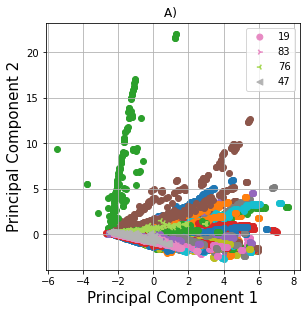

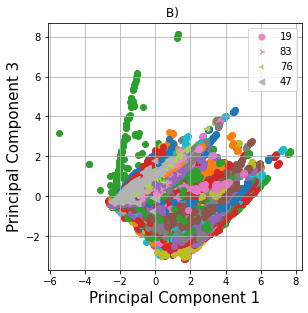

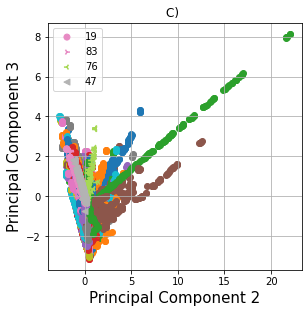

In [466]:
import matplotlib.ticker as mtick
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import matplotlib.markers as markers

import matplotlib.markers as markers

# Get a list of all available markers
marker_list = list(markers.MarkerStyle.markers.keys())

outputvalsname =  ['cs','coa','cod','cca','ccd','co2','css2']#'cl',
takeOut =[]


selectedSets = set( df['pSet'].unique())- psetCaCxa-pSethighCoCc-pSethighC-pSethighCoCcBis


# Separating out the features
x = dfa[outputvalsname]

# Separating out the target
y = df['pSet']
target = df['pSet']# pd.DataFrame(data = y , columns = ['pSet_id'])

# Standardizing the features
x = StandardScaler().fit_transform(x)

numComp = 3

pca = PCA(n_components=numComp)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component '+str(i+1) for i in range(numComp)])


finalDf = pd.concat([principalDf, target] , axis = 1)
#finalDf['outlier'] = [idd in np.array([1, 8, 13, 14, 18, 26, 44, 51, 52, 62, 63, 64, 69, 72, 74, 78, 80, 83, 91, 92, 93]) 
#                      for idd in finalDf['pSet']]

numMarker=13
numCol = 8

marker_id =np.array( [[i]*numCol for i in range(numMarker)]).reshape(-1)[:99]
color_id  =np.array( [[i for i in range(numCol)]*numMarker]).reshape(-1)[:99]

pSet2mark = dict(zip(np.unique(df['pSet']), marker_id))
pSet2col = dict(zip(np.unique(df['pSet']), color_id))
markers_map = dict(zip(np.array([i for i in range(numMarker)]),marker_id))
markers_map2markers_list = dict(zip(markers_map,marker_list))


# List of colors in the color palettes
rgb_values = sns.color_palette("Set2", 8)
color_map = dict(zip(np.array([i for i in range(8)]),rgb_values))

finalDf['color'] = finalDf['pSet'].map(pSet2col).map(color_map)


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(2,2,1)#projection='3d') 
        
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

for pset in range(99):
    subset = finalDf[finalDf['pSet']==pset]
    if ( len(subset) > 0) and (pset not in takeOut) and (pset not in selectedSets):
        ax.scatter(subset[ 'principal component 1']
                   , subset['principal component 2']
                   #, c = subset['color'] 
                   #, marker= markers_map2markers_list[pSet2mark[pset]]
                   )

for pset in selectedSets:
    subset = finalDf[finalDf['pSet']==pset]
    ax.scatter(subset[ 'principal component 1']
               , subset['principal component 2'],
                c = subset['color'] ,
               alpha=1, 
           zorder=100,label=f'{pset}'
               , marker= markers_map2markers_list[pSet2mark[pset]]
               )
    plt.legend()
        
ax.set_title(chr(ord('@')+1)+") ")
ax.grid()# the one near 30 is no 74

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(2,2,2)#projection='3d') 
        
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)

for pset in range(99):
    subset = finalDf[finalDf['pSet']==pset]
    if ( len(subset) > 0) and (pset not in takeOut) and (pset not in selectedSets):
        ax.scatter(subset[ 'principal component 1']
                   , subset['principal component 3']
                   
                   #, c = subset['color'] 
                   #, marker= markers_map2markers_list[pSet2mark[pset]]
                   )
        #print(pset,markers_map2markers_list[pSet2mark[pset]], end=", ")

for pset in selectedSets:
    subset = finalDf[finalDf['pSet']==pset]
    ax.scatter(subset[ 'principal component 1']
               , subset['principal component 3'],
                c = subset['color'] ,
               alpha=1, 
           zorder=100,label=f'{pset}'
               , marker= markers_map2markers_list[pSet2mark[pset]]
               )
    plt.legend()
        
ax.set_title(chr(ord('@')+2)+") ")
ax.grid()# the one near 30 is no 74

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(2,2,3)#projection='3d') 
        
ax.set_title(chr(ord('@')+3)+") ")
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)

for pset in range(99):
    subset = finalDf[finalDf['pSet']==pset]
    if ( len(subset) > 0) and (pset not in takeOut) and (pset not in selectedSets):
        ax.scatter(subset[ 'principal component 2']
                   , subset['principal component 3']
                   #, c = subset['color'] 
                   #, marker= markers_map2markers_list[pSet2mark[pset]]
                   )

for pset in selectedSets:
    subset = finalDf[finalDf['pSet']==pset]
    ax.scatter(subset[ 'principal component 2']
               , subset['principal component 3'],
                c = subset['color'] ,
               alpha=1, 
           zorder=100,label=f'{pset}'
               , marker= markers_map2markers_list[pSet2mark[pset]]
               )
    plt.legend()

ax.grid()# the one near 30 is no 74
plt.show()

In [456]:
finalDf[finalDf['principal component 2']>20]

,principal component 1,principal component 2,principal component 3,pSet,color
15819,1.203837,21.599246,7.967501,74,"(0.5529411764705883, 0.6274509803921569, 0.796..."
15823,1.203578,21.583728,7.961342,74,"(0.5529411764705883, 0.6274509803921569, 0.796..."
15891,1.225187,21.705059,8.009890,74,"(0.5529411764705883, 0.6274509803921569, 0.796..."
15940,1.286014,22.035850,8.141171,74,"(0.5529411764705883, 0.6274509803921569, 0.796..."
15941,1.286355,22.022718,8.136302,74,"(0.5529411764705883, 0.6274509803921569, 0.796..."


In [457]:
print(pca.explained_variance_ratio_,sum(pca.explained_variance_ratio_))

[0.57932614 0.20621903 0.12899901] 0.914544180870697
